<a href="https://colab.research.google.com/github/arthbohra/Biomedical-Image-Processing/blob/main/MRI_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Install Kaggle**

In [ ]:
!pip install -q kaggle
!cp kaggle.json ~/.kaggle/
!mkdir ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

**Download the Dataset**

In [ ]:
! kaggle datasets download -d abhranta/brain-tumor-detection-mri

**Unzip the Dataset**

In [ ]:
!unzip \*.zip && rm*.zip

**Download Packages**

In [29]:
import json
import os
import configparser
from datascience import *
import random 
import io
import pandas as pd
from tensorflow.keras.preprocessing.image import *
import shutil
from google.colab.patches import cv2_imshow
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import os
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
import json
import csv
import cv2

**Plot Example**

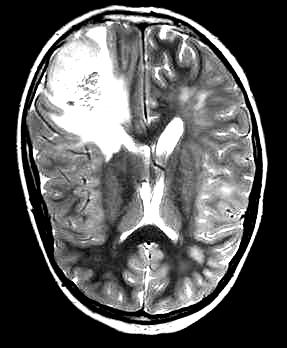

In [9]:
# plotting an example MRI scan
example = "/content/Brain_Tumor_Detection/yes/y0.jpg"
example_plot = plt.imread(example)
cv2_imshow(example_plot) 

**Create Directories**

In [10]:
paths = ["/content/training/yes", "/content/training/no", "/content/test/yes", "/content/test/no", "/content/validation/yes", "/content/validation/no"]
for path in paths:
  os.makedirs(path)

**Moving Data to Relevant Directories**

In [11]:
directory = "/content/Brain_Tumor_Detection"
categories = ["yes", "no"]
for category in categories:
    path = os.path.join(directory, category)
    i = 0
    for img in os.listdir(path):
      img_path = os.path.join(path, img)
      if i < 1000:
        shutil.move(img_path, ("/content/training/" + category))
      elif i < 1250:
        shutil.move(img_path, ("/content/test/" + category))
      elif i < 1500:
        shutil.move(img_path, ("/content/validation/" + category))
      i += 1

**Display the Distribution of the Dataset**

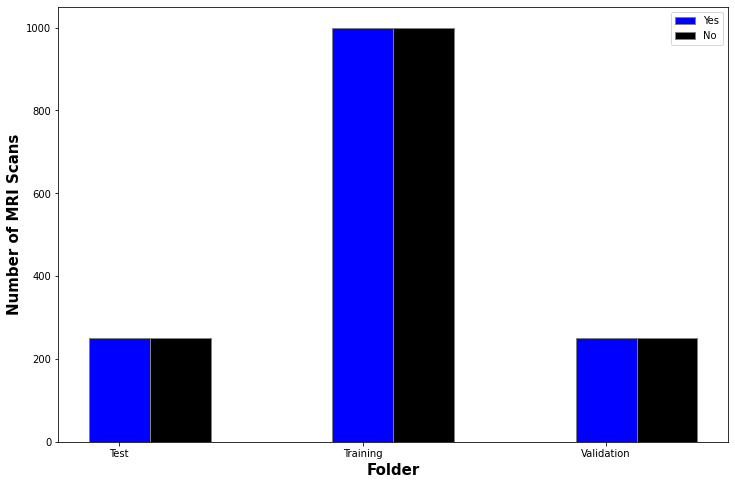

In [12]:
%matplotlib notebook
%matplotlib inline
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
 
# set height of bar
Yes = [250, 1000, 250]
No = [250, 1000, 250]
 
# Set position of bar on X axis
br1 = np.arange(len(Yes))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
# Make the plot
plt.bar(br1, Yes, color ='b', width = barWidth,
        edgecolor ='grey', label ='Yes')
plt.bar(br2, No, color ='black', width = barWidth,
        edgecolor ='grey', label ='No')
 
# Adding Xticks
plt.xlabel('Folder', fontweight ='bold', fontsize = 15)
plt.ylabel('Number of MRI Scans', fontweight ='bold', fontsize = 15)
plt.xticks(np.arange(3), labels = ["Test", "Training", "Validation"])
plt.legend()
plt.show()

**Create Training Data**

In [13]:
def create_training_data(direct):
  x = []
  y = []
  directory = direct
  categories = ["yes", "no"]
  for category in categories:
    path = os.path.join(directory, category)
    class_num = categories.index(category)
    for img in os.listdir(path):
      try:
        img_array = cv2.imread(os.path.join(path, img))
        x.append(img_array)
        y.append(class_num)
      except Exception as e:
        pass
  return np.array(x), np.array(y)

**Populate the Directories**

In [ ]:
x_train, y_train = create_training_data("/content/training")
x_test, y_test = create_training_data("/content/test")
x_valid, y_valid = create_training_data("/content/validation")

**Example of Augmenting the Data**

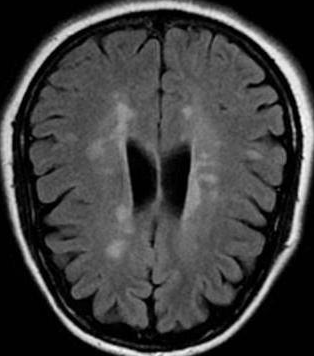

In [22]:
#read the image
img = cv2.imread("/content/test/no/No13.jpg")
#blur the image
blurred = cv2.blur(img, (3,3))

#detect the edges of the MRI scan
canny = cv2.Canny(blurred, 50, 200)

## find the bounding boxes of the MRI Scan to isolate the brain
pts = np.argwhere(canny>0)
y1,x1 = pts.min(axis=0)
y2,x2 = pts.max(axis=0)

## crop
cropped = img[y1:y2, x1:x2]

#display
cv2_imshow(cropped)

**Create Function to Augment Images**

In [23]:
def augment_image(img_path):
  #read the image
  img = cv2.imread(img_path)

  #blur the image
  blurred = cv2.blur(img, (3,3))

  #detect the edges of the MRI scan
  canny = cv2.Canny(blurred, 50, 200)

  ## find the bounding boxes of the MRI Scan to isolate the brain
  pts = np.argwhere(canny>0)
  y1,x1 = pts.min(axis=0)
  y2,x2 = pts.max(axis=0)

  ## crop
  cropped = img[y1:y2, x1:x2]

  #display
  cv2.imwrite(img_path, cropped)

**Augmenting the Entire Dataset**

In [24]:
directories = ["/content/test", "/content/validation", "/content/training"]
for directory in directories:
  categories = ["yes", "no"]
  for category in categories:
    path = os.path.join(directory, category)
    for img in os.listdir(path):
      img_path = os.path.join(path, img)
      augment_image(img_path)

**Normalizing the Dimensions of the Array**

In [30]:
def resize(directory):
  categories = ["yes", "no"]
  x = []
  y = []
  for category in categories:
    path = os.path.join(directory, category)
    for img in os.listdir(path):
      img_path = os.path.join(path, img)
      img_array = cv2.imread(os.path.join(path, img))
      resized_image = cv2.resize(img_array, dsize = (224, 224), interpolation=cv2.INTER_CUBIC)
      x.append(resized_image)
      y.append(categories.index(category))
  return np.array(x), np.array(y)

**Apply the Resizing to all of the Data**

In [32]:
x_train_new, y_train_new = resize("/content/training")
x_test_new, y_test_new = resize("/content/test")
x_valid_new, y_valid_new = resize("/content/validation")

**Display the New Data Example**

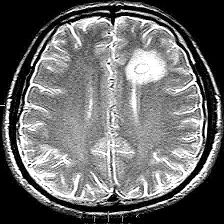

In [35]:
cv2_imshow(x_train_new[0])

In [ ]:
x, y = [], []
for features, label in training_data:
  x.append(features)
  y.append(label)
x = np.array(x).reshape(-1, 100, 100, 1)

In [ ]:
import pickle 

pickle_out = open("x.pickle", "wb")
pickle.dump(x, pickle_out)
pickle_out.close()

pickle_out = open("y.pickle", "wb")
pickle.dump(y, pickle_out)
pickle_out.close()

In [ ]:
x = pickle.load(open("x.pickle", "rb"))
y = pickle.load(open("y.pickle", "rb"))

In [ ]:
x = x / 255.0
y = np.array(y)

model = Sequential()

model.add(Conv2D(64, (3,3), input_shape = x.shape[1:]))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(64, (3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Flatten())
model.add(Dense(64))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])

model.fit(x, y, batch_size = 25, validation_split = 0.1)

108/108 [==============================] - 67s 598ms/step - loss: 0.6952 - accuracy: 0.4907 - val_loss: 0.6941 - val_accuracy: 0.4667
